# jaxpulse Testing

In [1]:
%load_ext autoreload
import jax.numpy as jnp
from jaxtyping import Array
import matplotlib.pyplot as plt
import dynamiqs as dq
import strawberryfields as sf
import os
from jaxpulse.controllers import ControlVector, SinusoidalControl, ConstantControl, FrequencyControl, GaussianControl, GaussianPulseTrain, GaussianShapeControl, GaussianHeightControl
from jaxpulse.optimizers import ClosedQuantumSystem, OpenQuantumSystem, OptimalController
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90'

### Simple Qubit Flip Pulse Control

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_40027/3008163740.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


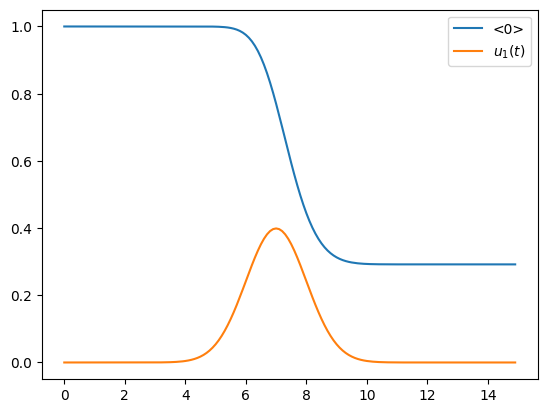

In [2]:
tls = ClosedQuantumSystem(
    H_0=dq.eye(2),
    H_M=[dq.sigmax()]
)
proj1 = dq.fock_dm(2,1)
proj0 = dq.fock_dm(2,0)
ctrl = OptimalController(
    system=tls,
    controls=ControlVector([GaussianHeightControl( # see also GaussianControl, GaussianShapeControl
        amp=jnp.array([1.0]),
        mean=jnp.array([7.0]),
        sigma=jnp.array([1.0]),
    )]),
    y0=dq.fock(2,0),
    duration=15.0,
    y_final=lambda psi_T: 1 - dq.expect(proj1, psi_T),
)
figpre,axpre = plt.subplots()
ctrl.plot(ax=axpre, exp_ops=[proj0],exp_names=["<0>"])
axpre.legend()
figpre.show()

In [3]:
ctrl2 = ctrl.optimize(N_steps=25,verbosity=2.0)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


ControlVector(
  us=[
    GaussianHeightControl(
      amp=Array([1.1473675], dtype=float32),
      mean=Array([7.], dtype=float32),
      sigma=Array([1.], dtype=float32)
    )
  ]
)
Step: 0 Loss: 0.2919468283653259
ControlVector(
  us=[
    GaussianHeightControl(
      amp=Array([1.2571921], dtype=float32),
      mean=Array([7.], dtype=float32),
      sigma=Array([1.], dtype=float32)
    )
  ]
)
Step: 1 Loss: 0.1688525676727295
ControlVector(
  us=[
    GaussianHeightControl(
      amp=Array([1.354499], dtype=float32),
      mean=Array([7.], dtype=float32),
      sigma=Array([1.], dtype=float32)
    )
  ]
)
Step: 2 Loss: 0.09518575668334961
ControlVector(
  us=[
    GaussianHeightControl(
      amp=Array([1.4427222], dtype=float32),
      mean=Array([7.], dtype=float32),
      sigma=Array([1.], dtype=float32)
    )
  ]
)
Step: 3 Loss: 0.04607272148132324
ControlVector(
  us=[
    GaussianHeightControl(
      amp=Array([1.5213848], dtype=float32),
      mean=Array([7.], dtype=float32)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_40027/4202681757.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


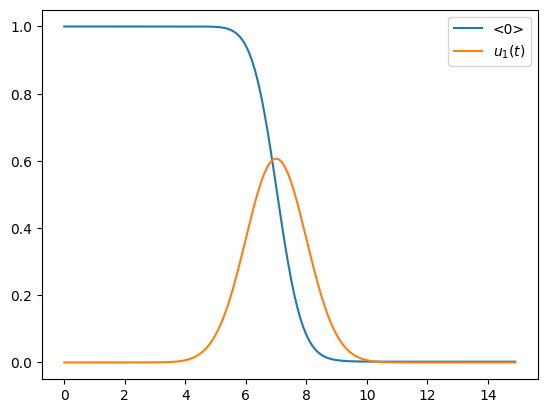

In [4]:

figpost, axpost = plt.subplots()
ctrl2.plot(ax=axpost,exp_ops=[proj0],exp_names=["<0>"])
axpost.legend()
figpost.show()

### Ancilla Reset Pulse Control

In [5]:
proj0 = dq.fock_dm(2,0)
proj1 = dq.fock_dm(2,1)
Delta = 1.
duration = 10.0
rho0 = dq.fock_dm(2,1)
gamma = 5
H_0 = dq.eye(2)
amp0 = jnp.sqrt(gamma)*dq.destroy(2)
tls = OpenQuantumSystem(
    H_0=H_0,
    H_M=[],
    U_K=[],
    C_K=[amp0]
)
loss_gaussian = ControlVector([
    GaussianHeightControl(
        amp=jnp.array([.5]),
        mean=jnp.array([duration/2]),
        sigma=jnp.array([.1])
    )
])
resetter = OptimalController(
    system=tls,
    controls=loss_gaussian,
    y0=rho0,
    duration=duration,
    y_final= lambda y: 1 - dq.expect(proj0, y)
)

<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_40027/2490421529.py:9: SyntaxWarning: invalid escape sequence '\h'
/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_40027/2490421529.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


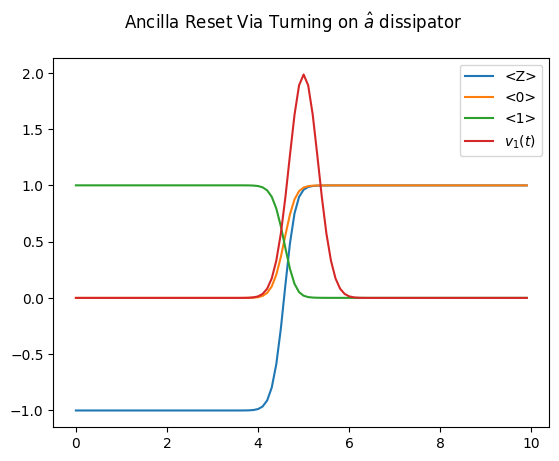

In [6]:
figpre, axpre = plt.subplots()
resetter.plot(
    ax=axpre,
    exp_ops=[dq.sigmaz(),proj0,proj1],
    exp_names=["<Z>","<0>","<1>"]
)
states = resetter.run(controls=loss_gaussian)
axpre.legend()
figpre.suptitle("Ancilla Reset Via Turning on $\hat{a}$ dissipator")
figpre.show()


### Optimal Control on Simple Systems: Driven JC Model

#### System Setup

In [7]:
N_res = 4
N_qub = 2
omega_res = 3.0
omega_qub = 2.2
g = .1

a = dq.tensor(dq.destroy(N_res), dq.eye(N_qub))
b = dq.tensor(dq.eye(N_res), dq.destroy(N_qub))
Z = dq.tensor(dq.eye(N_res), dq.number(N_qub))
H_0 = omega_res * dq.dag(a)@a + omega_qub * dq.dag(b)@b # static Hamiltonian
H_1 = dq.dag(a) @ b + a @ dq.dag(b) # coupling
H_2 = 1./jnp.sqrt(2)*(a + dq.dag(a)) # X
H_3 = 1j/jnp.sqrt(2)*(dq.dag(a) - a) # P
H_M = [H_1, H_2]
psi_0 = dq.tensor(dq.fock(N_res,0),dq.fock(N_qub,0))


#### Control Setups

In [8]:
coupling_control = GaussianControl(
    amp=jnp.array([1.0, 1.0]),
    mean=jnp.array([5.0, 10.0]),
    sigma=jnp.array([1.0, 1.0])
)
drive_X = GaussianControl(
    amp=jnp.ones((4,)),
    mean=jnp.linspace(2,12,4),
    sigma=jnp.ones((4,))
)
drive_X = GaussianPulseTrain(
    amp =jnp.array([1.0]),
    mean=jnp.array([4.0]),
    sigma=jnp.array([.5]),
    period=jnp.array([6.0])
)

#### Optimizer Setup

In [9]:
jc_system = ClosedQuantumSystem(
    H_0=H_0,
    H_M=H_M
)

jc_controls = ControlVector(
    [
        coupling_control,
        drive_X,
    ]
)

def final_penalty(psi_tF: Array) -> float:
    return 1 - dq.expect(Z, psi_tF)

duration= 15.0
controller = OptimalController(
    system=jc_system,
    controls=jc_controls,
    y0=psi_0,
    duration=duration,
    dt_start=.01,
    dt_save=.1,
    y_final=final_penalty,
)

#### Pre-Training

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_40027/105300645.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


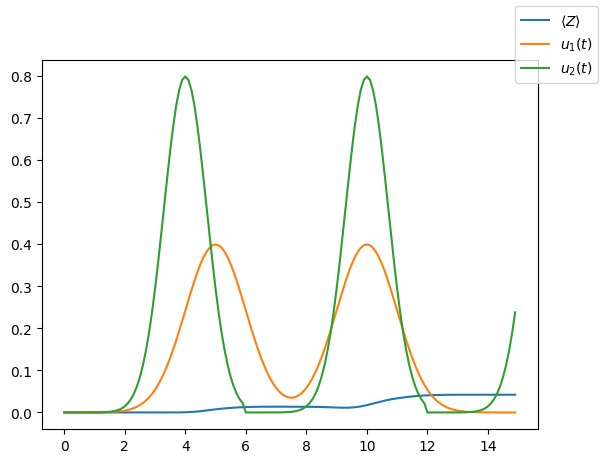

In [10]:
fig, ax = plt.subplots()
controller.plot(
    ax=ax,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"],
)
fig.legend()
fig.show()

#### Training

In [11]:
new_controller = controller.optimize(
    N_steps=40,
    learning_rate=.1,
    verbosity=2,
)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.1473674, 1.1473674], dtype=float32),
      mean=Array([ 4.8526335, 10.1473675], dtype=float32),
      sigma=Array([0.8526326 , 0.85263264], dtype=float32)
    ),
    GaussianPulseTrain(
      amp=Array([1.1473674], dtype=float32),
      mean=Array([3.8526325], dtype=float32),
      sigma=Array([0.35263258], dtype=float32),
      period=Array([5.852633], dtype=float32)
    )
  ]
)
Step: 0 Loss: 0.9578452110290527
ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.2758566, 1.2758125], dtype=float32),
      mean=Array([ 4.972627, 10.275696], dtype=float32),
      sigma=Array([0.72427315, 0.7244752 ], dtype=float32)
    ),
    GaussianPulseTrain(
      amp=Array([1.2749703], dtype=float32),
      mean=Array([3.7249007], dtype=float32),
      sigma=Array([0.22667295], dtype=float32),
      period=Array([5.971375], dtype=float32)
    )
  ]
)
Step: 1 Loss: 0.7501250505447388
ControlVector(
  us=[
    GaussianControl(
   

#### Post-Training

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_40027/1590037031.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


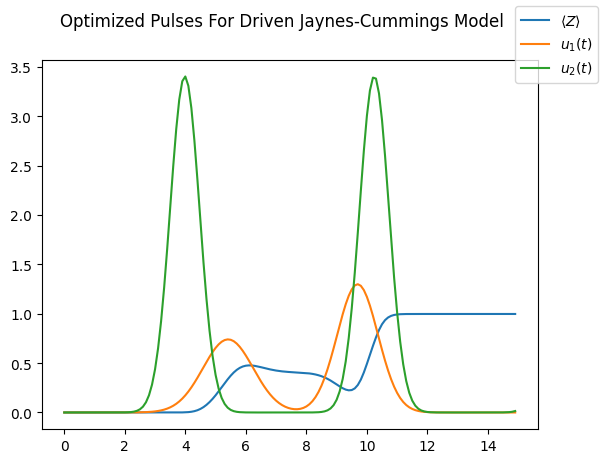

In [12]:
fig_opt, ax_opt = plt.subplots()
new_controller.plot(
    ax_opt,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"]
)
fig_opt.legend()
fig_opt.suptitle("Optimized Pulses For Driven Jaynes-Cummings Model")
fig_opt.show()

### Open System Demos

In [13]:
U_0 = jnp.sqrt(.1)*a
open_sys = OpenQuantumSystem(
    H_0=H_0,
    H_M=H_M,
    U_K=[U_0],
    C_K=[]
)
open_controls = jc_controls

open_controller = OptimalController(
    system=open_sys,
    controls=open_controls,
    y0=dq.todm(psi_0),
    duration=duration,
    y_final=final_penalty
)

#### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_40027/2901399393.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


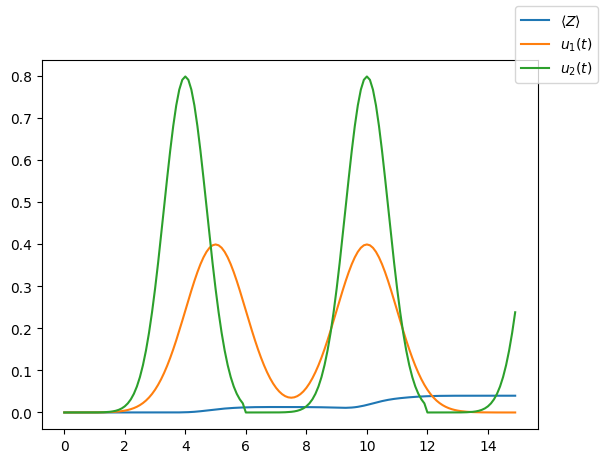

In [14]:
fig_pre, ax_pre = plt.subplots()
open_controller.plot(
    ax=ax_pre,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"],
)
fig_pre.legend()
fig_pre.show()

#### Train

In [15]:
opt_open_controller = open_controller.optimize(
    N_steps=100,
    verbosity=2,
)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.1473674, 1.1473674], dtype=float32),
      mean=Array([ 4.852633 , 10.1473675], dtype=float32),
      sigma=Array([0.85263264, 0.85263264], dtype=float32)
    ),
    GaussianPulseTrain(
      amp=Array([1.1473675], dtype=float32),
      mean=Array([3.8526328], dtype=float32),
      sigma=Array([0.35263258], dtype=float32),
      period=Array([5.8526325], dtype=float32)
    )
  ]
)
Step: 0 Loss: 0.9601852297782898
ControlVector(
  us=[
    GaussianControl(
      amp=Array([1.2758385, 1.2758825], dtype=float32),
      mean=Array([ 4.965561, 10.275292], dtype=float32),
      sigma=Array([0.72436017, 0.7243128 ], dtype=float32)
    ),
    GaussianPulseTrain(
      amp=Array([1.2750516], dtype=float32),
      mean=Array([3.7246094], dtype=float32),
      sigma=Array([0.22655672], dtype=float32),
      period=Array([5.9684644], dtype=float32)
    )
  ]
)
Step: 1 Loss: 0.7726175785064697
ControlVector(
  us=[
    GaussianControl(
 

#### Post-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_40027/353207557.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


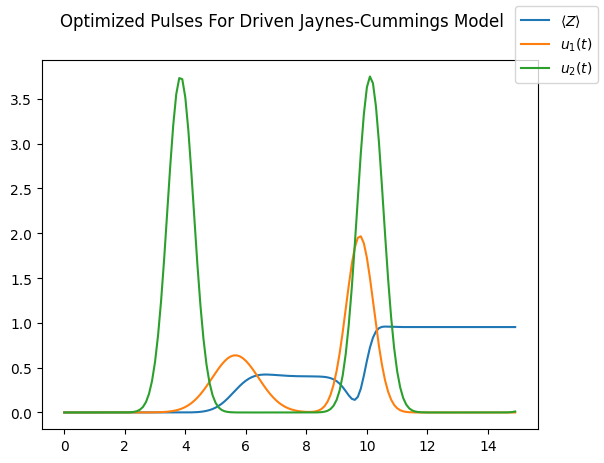

In [16]:
fig_open_opt, ax_open_opt = plt.subplots()
opt_open_controller.plot(
    ax_open_opt,
    exp_ops=[Z],
    exp_names=[r"$\langle Z\rangle$"]
)
fig_open_opt.legend()
fig_open_opt.suptitle("Optimized Pulses For Driven Jaynes-Cummings Model")
fig_open_opt.show()
